Argo Workflows is an open-source container-native workflow engine for orchestrating parallel jobs on Kubernetes. It provides a powerful, yet flexible framework to define, schedule, and manage complex workflows and tasks as Directed Acyclic Graphs (DAGs) of Kubernetes resources. You can sign in via the intuitive Argo Workflows UI to submit templates, run jobs, and monitor their progress in real-time. Alternatively, you can use the `swagger_client` Python package, developed by CUAHSI and available on [GitHub](https://github.com/CUAHSI/argo-workflow-python-client), to interact with Argo Workflows programmatically. This approach enables you to make API requests and manage workflows directly from a Jupyter Notebook, providing a seamless integration for data scientists and developers working within a notebook environment.

## Run simple templates

#### Installs a Python package directly from a GitHub repository.

In [5]:
!pip install git+https://github.com/CUAHSI/argo-workflow-python-client.git | tail -n 1

import swagger_client

  Running command git clone --filter=blob:none --quiet https://github.com/CUAHSI/argo-workflow-python-client.git /tmp/pip-req-build-c5_l263r


#### Define parameters.
Sign In and Obtain Bearer Token. A Bearer Token is a type of access token that is used to authenticate API requests. In the context of Argo Workflows and many other APIs, a Bearer Token is a security token that grants the bearer access to certain resources or APIs. The term "bearer" signifies that whoever possesses the token can use it to access the API, hence it must be kept secure.Bearer Tokens are typically short-lived for security reasons and need to be refreshed periodically.

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px;">
  <ul>
    <li>Sign in to the Argo Workflows UI with your credentials (HydroShare account).</li>
    <li>Open Developer Tools in your browser (usually by right-clicking the page and selecting "Inspect" or pressing Ctrl+Shift+I).</li>
    <li>Go to the <strong>Network</strong> tab.</li>
    <li>Refresh the page or trigger an API request by interacting with the UI.</li>
    <li>
      Look for a network request to the Argo API (it should contain BearerToken in the headers).
      <ul>
        <li>Click on a relevant request (like userinfo).</li>
        <li>In the right panel, navigate to "Headers".</li>
        <li>Scroll down in the headers list to find Authorization.</li>
      </ul>
    </li>
    <li>Copy the token from the request headers.</li>
  </ul>
</div>

The only other parameters you need to provide are the watershed boundary and VPU IDs for the region of your interest, and you need to define a start and end time.

In [47]:
# Configure API key authorization: BearerToken
configuration = swagger_client.Configuration()
configuration.api_key['Authorization'] = 'Bearer v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.50DFngEGBftEBpLsDqQUs8dC488gAx6xq9UdbpYg_NOnUMYEla4dYaomE0w61oXPUQdiFNYMuStHNc0Z3myVt52q4ehA4J_kdPsU-WB3AWV1r6v6bg0dJRP724iEzPcD86030pd_NZRioDhQCdEY9cV0iqZ0fkZW4uLtlcX9lsFhI43_OQ0KmGQsajTrvUTbtcD41wSLSrQi55I2p5B7TcJkontVSVsqW-CAld2ifLyd5owcuiDtaNJDlNUlL6cGZhpRjjD29FqlRMeLWTuqsPjtGuQf_VdeRtDqAKYbcxgNUQZsHiQM8ImluSRFNUJEmJFCYEMUC4iv0XCsXIcLNw.b-fgpP7Mz85XfsXN.RqFQLlSRqadq_2YuQwCHJCOo3_iu1q05S_G-iwWNjeewk9Q3Y9Hye2-GhbpOKy4FZgnatPIvNKDVRlmuI-XjJuBEQv-v5_SMzLanoBukDDHZHa8Kg7KZ_jhL9RlXTNW-LTreoxWPQGA0n-FAtPqusZp_BFGseUvFSI2w5b8xc751e7QV0WawfZh5LwnY_2t9_KSk2b980b_2FAiUlWLiShR765jOGpt9ukFfNTCjFUfOjxC4PYlqBJnAswNc39hVv9dlRdAzp-hg2uOg-O9mRdKr_g.xFqeOSQTivYeSMDCkovDsg'
configuration.host = "https://workflows.argo.cuahsi.io"
template_api_instance = swagger_client.WorkflowTemplateServiceApi(swagger_client.ApiClient(configuration))
workflow_api_instance = swagger_client.WorkflowServiceApi(swagger_client.ApiClient(configuration))

namespace = 'workflows'
output_bucket = "subsetter-outputs"    
output_path = "igarousi/ngen_results_test"

In [7]:
def submit_workflow_body(template_name: str, parameters: dict):
    parameters_list = [f"{key}={value}" for key, value in parameters.items()]
    return {
        "resourceKind": "WorkflowTemplate",
        "resourceName": template_name,
        "submitOptions": {
            "parameters":parameters_list,
        }
    }

In [8]:
def wait_for_completion(workflow_id):
    import time
    my_submitted_workflow = workflow_api_instance.workflow_service_get_workflow(namespace, workflow_id)
    phase = my_submitted_workflow.status.phase
    print(phase)
    while my_submitted_workflow.status.phase == 'Running':
        my_submitted_workflow = workflow_api_instance.workflow_service_get_workflow(namespace, workflow_id)
        phase = my_submitted_workflow.status.phase
        print(phase)
        time.sleep(5)

### Change configs


<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px;">
  <ul>
    <strong>‘refkdt’</strong> is actually runoff/infiltration rate and you can learn more about it in this article. This parameter is manually calibrated over multiple simulations and significantly impacts surface infiltration and hence the partitioning of total runoff into surface and subsurface runoff. <strong>Increased values of REFKDT leads to more infiltration and less surface runoff.</strong>

  </ul>
</div>

In [1]:
import fsspec
import utils

cat_sel = 'cat-2851642'
base_path = 's3://subsetter-outputs/igarousi/ngen_results_test/'
endpoint_url = 'https://api.minio.cuahsi.io'
fs = fsspec.filesystem('s3', client_kwargs={'endpoint_url': endpoint_url}, anon=True)

config_path = base_path + 'config/' +  f'{cat_sel}_config.ini'
config_dict = utils.load_config(config_path, endpoint_url, fs)
config_dict

{'forcing_file': 'BMI',
 'soil_params.depth': '2.0[m]',
 'soil_params.b': '3.754239797592163[]',
 'soil_params.satdk': '1.2438571325041682e-06[m s-1]',
 'soil_params.satpsi': '0.0233870272921526[m]',
 'soil_params.slop': '0.4666266063168737[m/m]',
 'soil_params.smcmax': '0.5168862306583611[m/m]',
 'soil_params.wltsmc': '0.0834221108995798[m/m]',
 'refkdt': '0',
 'soil_params.expon': '1.0[]',
 'soil_params.expon_secondary': '0.005[]',
 'max_gw_storage': '248.328295278[m]',
 'Cgw': '0.0018[m h-1]',
 'expon': '6.0[]',
 'gw_storage': '0.05[m/m]',
 'alpha_fc': '0.33[]',
 'soil_storage': '0.05[m/m]',
 'K_nash': '0.03[]',
 'K_lf': '0.01[]',
 'nash_storage': '0.0,0.0',
 'giuh_ordinates': '1.0,0.0',
 'num_timesteps': '1',
 'verbosity': '0',
 'surface_partitioning_scheme': 'Schaake'}

In [3]:
# change the value
var_name = 'refkdt'
var_value = '0'
utils.change_config(fs, config_path, config_dict, var_name, var_value)

Configuration updated successfully.


In [4]:
# view changes
config_dict = utils.load_config(config_path, endpoint_url, fs)
config_dict

{'forcing_file': 'BMI',
 'soil_params.depth': '2.0[m]',
 'soil_params.b': '3.754239797592163[]',
 'soil_params.satdk': '1.2438571325041682e-06[m s-1]',
 'soil_params.satpsi': '0.0233870272921526[m]',
 'soil_params.slop': '0.4666266063168737[m/m]',
 'soil_params.smcmax': '0.5168862306583611[m/m]',
 'soil_params.wltsmc': '0.0834221108995798[m/m]',
 'refkdt': '0',
 'soil_params.expon': '1.0[]',
 'soil_params.expon_secondary': '0.005[]',
 'max_gw_storage': '248.328295278[m]',
 'Cgw': '0.0018[m h-1]',
 'expon': '6.0[]',
 'gw_storage': '0.05[m/m]',
 'alpha_fc': '0.33[]',
 'soil_storage': '0.05[m/m]',
 'K_nash': '0.03[]',
 'K_lf': '0.01[]',
 'nash_storage': '0.0,0.0',
 'giuh_ordinates': '1.0,0.0',
 'num_timesteps': '1',
 'verbosity': '0',
 'surface_partitioning_scheme': 'Schaake'}

### Resubmit NGEN-RUN with updated data

In [51]:
parameters = {
    "input-data-bucket": output_bucket,
    "input-data-path": output_path,
    "catchment-file-path": "domain/catchments.geojson",
    "nexus-file-path": "domain/nexus.geojson",
    "realization-file-path": "config/realization.json",
    "output-bucket": output_bucket,
    "output-path": output_path,
}
body = submit_workflow_body("ngen-run", parameters)
api_response = workflow_api_instance.workflow_service_submit_workflow(namespace, body)


In [ ]:
wait_for_completion(api_response.metadata.name)

Running
Running


## Check results

In [5]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import fsspec
import utils
import os

# Define the base path and define a path to save outputs
base_path = 's3://subsetter-outputs/igarousi/ngen_results_test/'
endpoint_url = 'https://api.minio.cuahsi.io'
fs = fsspec.filesystem('s3', client_kwargs={'endpoint_url': endpoint_url}, anon=True)
isExist = os.path.exists('outputs')
if isExist == True:
    exit
else:
    os.mkdir('outputs')

In [6]:
catchments_path = base_path + 'domain/' + 'catchments.geojson'
attributes_path = base_path + 'domain/' + 'cfe_noahowp_attributes.csv'
flowpaths_path = base_path + 'domain/' + 'flowpaths.geojson'
nexus_path = base_path + 'domain/' + 'nexus.geojson'
gpkg_path = base_path + 'domain/' + 'wb-2851653_upstream_subset.gpkg'
catchments = gpd.read_file(fs.open(catchments_path))
flowpaths = gpd.read_file(fs.open(flowpaths_path))
nexus = gpd.read_file(fs.open(nexus_path))
attributes = pd.read_csv(fs.open(attributes_path))  # cfe_noahowp_attributes.csv
with fs.open(gpkg_path) as f:
    gdf_flow = gpd.read_file(f, layer='flowpaths')
    f.seek(0)  # Reset file pointer
    gdf_cat = gpd.read_file(f, layer='divides')
    f.seek(0)  # Reset file pointer
    gdf_nexus = gpd.read_file(f, layer='nexus')

In [7]:
nex_csvfiles = fs.glob(base_path + 'results/' + 'nex*.csv')
cat_csvfiles = fs.glob(base_path + 'results/' + 'cat*.csv')
forcing_csvfiles = fs.glob(base_path + 'forcing/' + 'cat*.csv')

xr_nex = utils.nex_csv2xr(fs, nex_csvfiles)
xr_cat = utils.cat_csv2xr(fs, cat_csvfiles)
xr_forcing = utils.forcing_csv2xr(fs, forcing_csvfiles)

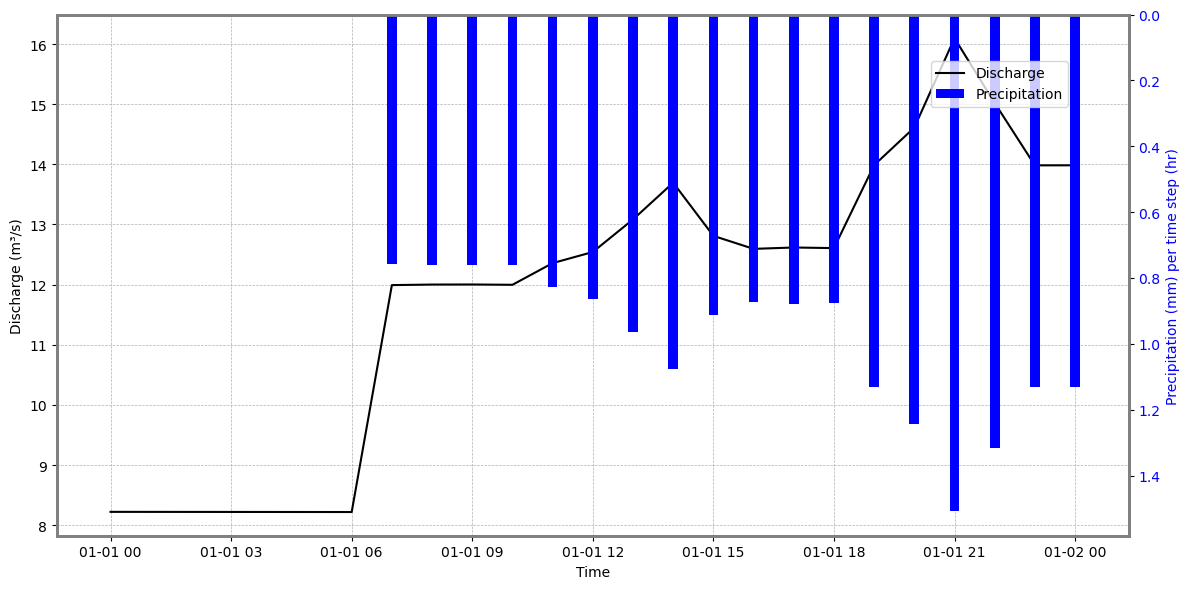

In [8]:
# Define the selected IDs and then plot precipitation and streamflow
cat_sel = 'cat-2851642'
nex_sel = gdf_flow.loc[gdf_flow['divide_id'] == cat_sel].toid.values[0]
utils.plot_precip_and_flow(cat_sel, nex_sel, xr_cat, xr_nex, xr_forcing)

In [9]:
# Save results
# xr_nex.to_netcdf('./outputs/sim2_nex_results_correctforcing.nc')
# xr_cat.to_netcdf('./outputs/sim2_cat_results_correctforcing.nc')
# xr_forcing.to_netcdf('./outputs/forcing_inputs_correctforcing.nc')

xr_nex.to_netcdf('./outputs/sim2_nex_results_correctforcing_refkdt.nc')
xr_cat.to_netcdf('./outputs/sim2_cat_results_correctforcing_refkdt.nc')
xr_forcing.to_netcdf('./outputs/forcing_inputs_correctforcing.nc')

### compare different simulation results

In [10]:
import xarray as xr
sim2_org = xr.open_mfdataset('./outputs/sim2_nex_results_correctforcing.nc')
sim2_mod = xr.open_mfdataset('./outputs/sim2_nex_results_correctforcing_refkdt.nc')

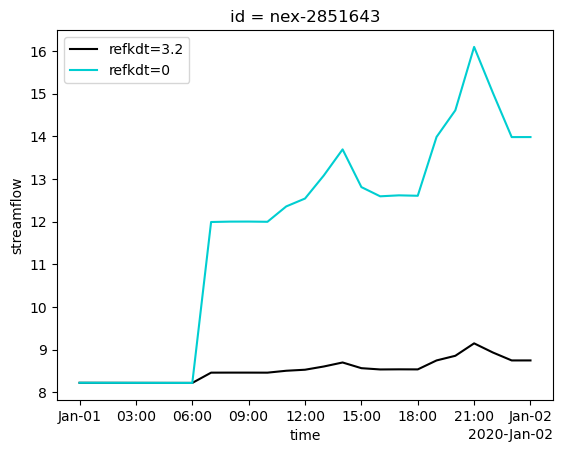

In [21]:
import matplotlib.pyplot as plt
sim2_org.sel(id=nex_sel).streamflow.plot(color='k', label='refkdt=3.2')
sim2_mod.sel(id=nex_sel).streamflow.plot(color='darkturquoise', label='refkdt=0')
plt.legend()
plt.show()